In [14]:
import findspark
findspark.init()

In [15]:
#import libbrary yang diperlukan
import os
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType
from pyspark.sql.functions import split, count, when, isnan, col, regexp_replace
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [16]:
#inisiasi spark session
spark = SparkSession.builder.appName('First Session').getOrCreate()

#chek versi spark
print('Spark Version: {}'.format(spark.version))

Spark Version: 3.5.0


In [17]:
#mendefinisikan schema
file_path = 'inflasi.csv'

df = spark.read.csv(file_path,
                    header = True,
                    inferSchema = True,
                    nanValue = '?')

df.show(5)

+----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|            Kota|2020-01|2020-02|2020-03|2020-04|2020-05|2020-06|2020-07|2020-08|2020-09|2020-10|2020-11|2020-12|2021-01|2021-02|2021-03|2021-04|2021-05|2021-06|2021-07|2021-08|2021-09|2021-10|2021-11|2021-12|2022-01|2022-02|2022-03|2022-04|2022-05|2022-06|2022-07|2022-08|2022-09|2022-10|2022-11|2022-12|2023-01|2023-02|2023-03|2023-04|2023-05|2023-06|2023-07|2023-08|2023-09|2023-10|2023-11|
+----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+

In [18]:
df_clean=df.na.drop()
df_clean.tail(5)

[Row(Kota='MANOKWARI', 2020-01=0.23, 2020-02=2.88, 2020-03=1.32, 2020-04=3.35, 2020-05=3.46, 2020-06=3.25, 2020-07=0.32, 2020-08=0.4, 2020-09=-0.84, 2020-10=-3.76, 2020-11=-3.33, 2020-12=-1.38, 2021-01=0.52, 2021-02=1.3, 2021-03=2.66, 2021-04=1.33, 2021-05=4.3, 2021-06=7.29, 2021-07=5.31, 2021-08=3.81, 2021-09=2.68, 2021-10=2.88, 2021-11=2.88, 2021-12=3.39, 2022-01=3.71, 2022-02=1.87, 2022-03=4.68, 2022-04=2.53, 2022-05=7.42, 2022-06=6.47, 2022-07=2.4, 2022-08=2.81, 2022-09=1.45, 2022-10=3.37, 2022-11=3.49, 2022-12=8.11, 2023-01=1.96, 2023-02=-0.37, 2023-03=-2.59, 2023-04=0.64, 2023-05=2.72, 2023-06=3.28, 2023-07=5.3, 2023-08=7.32, 2023-09=3.42, 2023-10=2.58, 2023-11=0.66),
 Row(Kota='SORONG', 2020-01=0.59, 2020-02=1.68, 2020-03=1.9, 2020-04=3.23, 2020-05=3.4, 2020-06=4.53, 2020-07=5.01, 2020-08=4.53, 2020-09=4.17, 2020-10=2.97, 2020-11=4.5, 2020-12=5.36, 2021-01=2.98, 2021-02=2.1, 2021-03=4.24, 2021-04=3.7, 2021-05=5.43, 2021-06=8.6, 2021-07=12.63, 2021-08=10.26, 2021-09=8.49, 2021-10

In [19]:
df_pandas = df_clean.toPandas()

In [20]:
data_long_pandas = pd.melt(df_pandas, id_vars=['Kota'], var_name='bulan', value_name='inflasi')
data= spark.createDataFrame(data_long_pandas)
data.show()

+----------------+-------+-------+
|            Kota|  bulan|inflasi|
+----------------+-------+-------+
|        MEULABOH|2020-01|   3.69|
|      BANDA ACEH|2020-01|   1.35|
|     LHOKSEUMAWE|2020-01|   0.19|
|         SIBOLGA|2020-01|   0.57|
|PEMATANG SIANTAR|2020-01|    1.7|
|           MEDAN|2020-01|   1.99|
| PADANGSIDIMPUAN|2020-01|   0.72|
|    GUNUNGSITOLI|2020-01|   3.22|
|          PADANG|2020-01|   2.13|
|     BUKITTINGGI|2020-01|   0.46|
|      TEMBILAHAN|2020-01|   1.02|
|       PEKANBARU|2020-01|   1.31|
|           DUMAI|2020-01|   1.61|
|           BUNGO|2020-01|   2.45|
|           JAMBI|2020-01|   2.63|
|       PALEMBANG|2020-01|   1.96|
|    LUBUKLINGGAU|2020-01|    1.0|
|        BENGKULU|2020-01|   0.86|
|  BANDAR LAMPUNG|2020-01|   2.97|
|           METRO|2020-01|   2.26|
+----------------+-------+-------+
only showing top 20 rows



In [21]:
feature_columns = data.columns[2:]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(data)

In [22]:
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=42)

In [23]:
k_values = list(range(2, 11))
costs = []

In [24]:
# Melakukan iterasi untuk setiap nilai k
for k in k_values:
    # Menginisialisasi dan melatih model KMeans
    kmeans = KMeans(k=k, seed=42)
    model = kmeans.fit(assembled_data)

    # Menghitung cost
    cost = model.summary.trainingCost
    costs.append(cost)

In [25]:
# Menampilkan hasil
for k, cost in zip(k_values, costs):
    print(f"K={k}, Cost={cost}")

K=2, Cost=9779.950135130348
K=3, Cost=5218.161596893357
K=4, Cost=3308.1355779120195
K=5, Cost=2273.7111313353353
K=6, Cost=1667.6374919285358
K=7, Cost=1365.635004043576
K=8, Cost=1063.6089844842752
K=9, Cost=840.8051396883359
K=10, Cost=683.9009280410341


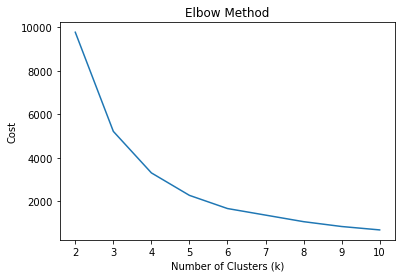

In [26]:
plt.plot(k_values, costs)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.show()

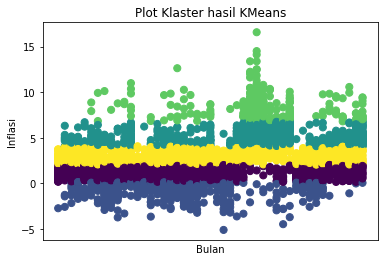

In [35]:
# Menggabungkan fitur menjadi satu kolom vektor
assembler = VectorAssembler(inputCols=["inflasi"], outputCol="features")
assembled_data = assembler.transform(data)

# Menentukan jumlah klaster
k_value = 5

# Inisialisasi dan melatih model KMeans dengan jumlah klaster yang ditentukan
kmeans = KMeans(k=k_value, seed=42)
model = kmeans.fit(assembled_data)

# Mendapatkan hasil klastering
predictions = model.transform(assembled_data)

# Ambil data hasil klastering dan fiturnya
result = model.transform(assembled_data).select("Kota", "bulan", "inflasi", "prediction").toPandas()

# Plotting scatter plot dengan warna klaster yang berbeda
plt.scatter(result["bulan"], result["inflasi"], c=result["prediction"], cmap='viridis', s=50)
plt.title('Plot Klaster hasil KMeans')
plt.xlabel('Bulan')
plt.ylabel('Inflasi')
plt.xticks([])

plt.show()

In [28]:
centroids = model.clusterCenters()

# Menampilkan centroid
print("Centroid dari Klaster:")
for i, centroid in enumerate(centroids):
    print(f"Klaster {i + 1}: {centroid}")

Centroid dari Klaster:
Klaster 1: [1.13392017]
Klaster 2: [-0.85524178]
Klaster 3: [5.1950719]
Klaster 4: [8.35887789]
Klaster 5: [2.93700483]


In [29]:
result.head()

,Kota,bulan,inflasi,prediction
0,MEULABOH,2020-01,3.69,4
1,BANDA ACEH,2020-01,1.35,0
2,LHOKSEUMAWE,2020-01,0.19,0
3,SIBOLGA,2020-01,0.57,0
4,PEMATANG SIANTAR,2020-01,1.70,0


In [31]:
data_hist= spark.createDataFrame(result)
data_hist.show()

+----------------+-------+-------+----------+
|            Kota|  bulan|inflasi|prediction|
+----------------+-------+-------+----------+
|        MEULABOH|2020-01|   3.69|         4|
|      BANDA ACEH|2020-01|   1.35|         0|
|     LHOKSEUMAWE|2020-01|   0.19|         0|
|         SIBOLGA|2020-01|   0.57|         0|
|PEMATANG SIANTAR|2020-01|    1.7|         0|
|           MEDAN|2020-01|   1.99|         0|
| PADANGSIDIMPUAN|2020-01|   0.72|         0|
|    GUNUNGSITOLI|2020-01|   3.22|         4|
|          PADANG|2020-01|   2.13|         4|
|     BUKITTINGGI|2020-01|   0.46|         0|
|      TEMBILAHAN|2020-01|   1.02|         0|
|       PEKANBARU|2020-01|   1.31|         0|
|           DUMAI|2020-01|   1.61|         0|
|           BUNGO|2020-01|   2.45|         4|
|           JAMBI|2020-01|   2.63|         4|
|       PALEMBANG|2020-01|   1.96|         0|
|    LUBUKLINGGAU|2020-01|    1.0|         0|
|        BENGKULU|2020-01|   0.86|         0|
|  BANDAR LAMPUNG|2020-01|   2.97|

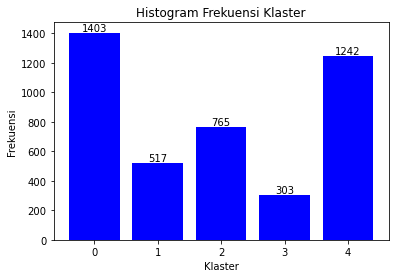

In [32]:
# Mengumpulkan frekuensi kemunculan tiap klaster
cluster_counts = data_hist.groupBy("prediction").count().orderBy("prediction").collect()

# Ekstraksi data untuk plotting
clusters = [row["prediction"] for row in cluster_counts]
frequencies = [row["count"] for row in cluster_counts]

# Plotting histogram dengan keterangan jumlah angka di atas diagram batang
fig, ax = plt.subplots()
bars = ax.bar(clusters, frequencies, color='blue')

# Menambahkan keterangan jumlah angka di atas diagram batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


# Plotting histogram
plt.bar(clusters, frequencies, color='blue')
plt.xlabel('Klaster')
plt.ylabel('Frekuensi')
plt.title('Histogram Frekuensi Klaster')
plt.show()